## Getting notebook setup

In [ ]:
### uncomment this and run
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# NOTE YOU WILL NEED TO CHANGE THIS TO YOUR OWN FOLDER OF DATA IN YOUR G DRIVE

%cd /content/drive/MyDrive/Classes/deeplearningOMS/final project/data/CS7643_group_project/data/DL data

/content/drive/MyDrive/Classes/deeplearningOMS/final project/data/CS7643_group_project/data/DL data


In [ ]:
# input: 3040 x 10
# target: 3040 x 16836

In [ ]:
import torch.nn as nn

# hyperparameters
batch_size = 32

criterion = nn.MSELoss()

epochs = 20


In [ ]:
# # Note you will need to change the '.csv' file names to your file names for the csv data

# import pandas as pd
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# # Function to create a DataLoader with the same random seed for shuffling
# def create_data_loader(data_tensor, batch_size, shuffle=True, drop_last=True):
#     random_seed = 42  # You can choose any seed you like
#     data_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, generator=torch.Generator().manual_seed(random_seed))
#     return data_loader

# # TRAIN_input
# csv_file_train = "train_input_matrix.csv"
# df = pd.read_csv(csv_file_train)
# data_tensor_train_input = torch.tensor(df.values, dtype=torch.float32)
# batch_size = batch_size
# data_loader_train_input = create_data_loader(data_tensor_train_input, batch_size, shuffle=True, drop_last=True)  # Set drop_last=True

# # TRAIN_target
# csv_file_train_target = "train_target_matrix.csv"
# df = pd.read_csv(csv_file_train_target)
# data_tensor_train_target = torch.tensor(df.values, dtype=torch.float32)
# data_loader_train_target = create_data_loader(data_tensor_train_target, batch_size, shuffle=True, drop_last=True)  # Set drop_last=True

# # TEST_input
# csv_file_test_input = "test_input_matrix.csv"
# df = pd.read_csv(csv_file_test_input)
# data_tensor_test_input = torch.tensor(df.values, dtype=torch.float32)
# data_loader_test_input = create_data_loader(data_tensor_test_input, batch_size, shuffle=False, drop_last=False)  # Keep all batches for testing

# # TEST_target
# csv_file_test_target = "test_target_matrix.csv"
# df = pd.read_csv(csv_file_test_target)
# data_tensor_test_target = torch.tensor(df.values, dtype=torch.float32)
# data_loader_test_target = create_data_loader(data_tensor_test_target, batch_size, shuffle=False, drop_last=False)  # Keep all batches for testing


## Load Data

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

# Function to create a DataLoader with the same random seed for shuffling
def create_data_loader(data_tensor, batch_size, shuffle=True, drop_last=True):
    random_seed = 42  # You can choose any seed you like
    data_loader = DataLoader(TensorDataset(*data_tensor), batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, generator=torch.Generator().manual_seed(random_seed))
    return data_loader

# Load and combine training data
csv_file_train_input = "train_input_matrix.csv"
csv_file_train_target = "train_target_matrix.csv"
df_train_input = pd.read_csv(csv_file_train_input)
df_train_target = pd.read_csv(csv_file_train_target)
data_tensor_train_input = torch.tensor(df_train_input.values, dtype=torch.float32)
data_tensor_train_target = torch.tensor(df_train_target.values, dtype=torch.float32)
data_loader_train = create_data_loader((data_tensor_train_input, data_tensor_train_target), batch_size, shuffle=True, drop_last=True)

# Load and combine testing data
csv_file_test_input = "test_input_matrix.csv"
csv_file_test_target = "test_target_matrix.csv"
df_test_input = pd.read_csv(csv_file_test_input)
df_test_target = pd.read_csv(csv_file_test_target)
data_tensor_test_input = torch.tensor(df_test_input.values, dtype=torch.float32)
data_tensor_test_target = torch.tensor(df_test_target.values, dtype=torch.float32)
data_loader_test = create_data_loader((data_tensor_test_input, data_tensor_test_target), batch_size, shuffle=False, drop_last=False)


In [ ]:
print(df_test_target.shape)

(1519, 16836)


In [ ]:
# final test:
# Load and combine final testing data
csv_file_final_test_input = "test_input_matrix.csv"
csv_file_final_test_target =  "test_target_matrix.csv"
df_final_test_input = pd.read_csv(csv_file_final_test_input)
df_final_test_target = pd.read_csv(csv_file_final_test_target)
data_tensor_final_test_input = torch.tensor(df_final_test_input.values, dtype=torch.float32)
data_tensor_final_test_target = torch.tensor(df_final_test_target.values, dtype=torch.float32)
data_loader_final_test = create_data_loader((data_tensor_final_test_input, data_tensor_final_test_target), batch_size=1, shuffle=False, drop_last=False)


## This is the Network Described in paper
We made multiple version of them to figure out which one worked the best

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(10, 31, kernel_size=2, padding=0)  # Adjust input channels to 10
        self.bn1 = nn.BatchNorm1d(31)
        self.conv2 = nn.Conv1d(31, 32, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        # Adjust the input size after flattening
        self.fc1 = nn.Linear(32, 512)

        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 16836)

        self.dropout = nn.Dropout(p=0.2)  # Set dropout rate to 0.2

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)  # Apply dropout with a rate of 0.2
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.dropout(x)  # Apply dropout with a rate of 0.2
        x = F.relu(self.bn5(self.fc3(x)))
        x = self.fc4(x)
        return x

# Create an instance of the ConvNet model
model = ConvNet()

criterion = nn.MSELoss()

# Set the optimizer
optimizer = optim.Adam(model.parameters())



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN_Model_BN(nn.Module):
    def __init__(self, steps, features, outputs):
        super(CNN_Model_BN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=features, out_channels=32, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(32)
        # self.fc1 = nn.Linear(32 * steps, 32)
        self.fc1 = nn.Linear(32, 32)

        self.bn3 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.bn4(self.fc2(x)))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.bn5(self.fc3(x)))
        x = self.fc4(x)
        return x

# Usage example
steps = 10  # Set the appropriate value for your data
features = 10  # Set the appropriate value for your data
outputs = 16836  # Set the appropriate value for your data

model = CNN_Model_BN(steps, features, outputs)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Assuming x_train, Y, x_test, and Y_test are your training and test data (tensors)
# Remember to convert your data into tensors before passing it to the model

# Training loop
epochs = 100  # Set the number of epochs you want to train
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(x_train)
#     loss = criterion(outputs, Y)
#     loss.backward()
#     optimizer.step()

# Evaluation
# model.eval()
# with torch.no_grad():
#     test_outputs = model(x_test)
#     test_loss = criterion(test_outputs, Y_test)
#     print("Test Loss:", test_loss.item())


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ConvNet_Chanyu(nn.Module):
    def __init__(self):
        super(ConvNet_Chanyu, self).__init__()
        # self.conv1 = nn.Conv1d(10, 31, kernel_size=2, padding=0)  # Adjust input channels to 10

        self.conv1 = nn.Conv1d(1, 31, kernel_size=2, padding=0)  # CY: change input channel: 10->1
        self.bn1 = nn.BatchNorm1d(31)
        self.conv2 = nn.Conv1d(31, 32, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        # Adjust the input size after flattening
        self.fc1 = nn.Linear(320, 512)  # CY : change input feature size: 32->320

        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 16836)

        self.dropout = nn.Dropout(p=0.2)  # Set dropout rate to 0.2

        # CY: add optimiser , criterion and device
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters())

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    def forward(self, x):

        x = torch.tensor(x, device=self.device, dtype=self.conv1.weight.dtype) # To fix your issue you can cast x to be the same type as the weight or bias parameters of the self.conv1 layer (assuming this is a nn.Conv*d layer).

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)  # Apply dropout with a rate of 0.2
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.dropout(x)  # Apply dropout with a rate of 0.2
        x = F.relu(self.bn5(self.fc3(x)))
        x = self.fc4(x)
        return x



In [ ]:
# HyperParameters
import torch
from torch.utils.data import DataLoader

# Set the device to run on: GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an instance of the ConvNet model
model = ConvNet_Chanyu().to(device)

# Set the loss function
criterion = nn.MSELoss()

# learning rate
# learning rate (default: 1e-3)

# Set the optimizer
optimizer = optim.Adam(model.parameters())

# Set the number of training epochs
epochs = 150

Epoch 1/150:   0%|          | 0/94 [00:00<?, ?it/s]<ipython-input-8-a9d9d943680c>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=self.device, dtype=self.conv1.weight.dtype) # To fix your issue you can cast x to be the same type as the weight or bias parameters of the self.conv1 layer (assuming this is a nn.Conv*d layer).


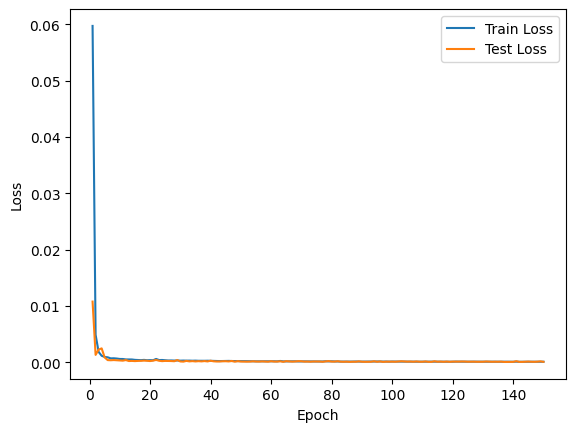

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_and_test_model(model, train_loader, test_loader, epochs=10, batch_size=32):
    # Set the loss function
    criterion = nn.MSELoss()

    # Set the optimizer
    optimizer = optim.Adam(model.parameters())

    # Lists to store the loss values for plotting
    train_loss_list = []
    test_loss_list = []

    # # Create data loaders
    # train_dataset = torch.utils.data.TensorDataset(train_data, train_targets)
    # train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # test_dataset = torch.utils.data.TensorDataset(test_data, test_targets)
    # test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Move model to the appropriate device (CPU or GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # print("we are here before loop")
    # Training loop with tqdm for progress bar
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        # print("we are here in 1 loop")

        count = 0

        for i, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            count += 1
            # print("we are here in 2 loop", count, inputs.shape)


            if(inputs.shape[0] == batch_size):

              inputs, targets = inputs.to(device), targets.to(device)
              inputs = inputs.unsqueeze(1)


              # Zero the gradients
              optimizer.zero_grad()

              # inputs = inputs.transpose(0, 1).contiguous()


              # inputs.unsqueeze(0)


              # Forward pass
              outputs = model(inputs)

              # print("THESE BE SHAPES O, T", outputs.shape, targets.shape)
              # Compute the loss
              loss = criterion(outputs, targets)

              # Backpropagation and optimization
              loss.backward()
              optimizer.step()

              # Update running loss
              running_loss += loss.item()

            # Display the loss for the current step
            if i % 100 == 99:
                print(f"Step {i+1}/{len(train_loader)} - Loss: {running_loss / 100:.6f}")
                running_loss = 0.0

        # Calculate and store the average training loss for this epoch
        avg_train_loss = running_loss / count #len(train_loader)
        train_loss_list.append(avg_train_loss)

        # Evaluate the model on the test set
        model.eval()  # Set the model to evaluation mode
        test_loss = 0.0

        count_test = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
             if(inputs.shape[0] == batch_size):
                  count_test += 1

                  inputs, targets = inputs.to(device), targets.to(device)
                  inputs = inputs.unsqueeze(1)

                  # Forward pass
                  outputs = model(inputs)

                  # Compute the test loss
                  test_loss += criterion(outputs, targets).item()

        # Calculate and store the average test loss for this epoch
        avg_test_loss = test_loss / count_test # len(test_loader)
        print()
        test_loss_list.append(avg_test_loss)

    # Plot the loss graph
    plt.plot(range(1, epochs+1), train_loss_list, label='Train Loss')
    plt.plot(range(1, epochs+1), test_loss_list, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Train and test the model
train_and_test_model(model, data_loader_train, data_loader_test, epochs=epochs, batch_size=batch_size)


In [ ]:
import torch
import torch.nn as nn
import torch

# # Function to save the model
# def save_model(model, path):
#     torch.save(model.state_dict(), path)

# # Save the model after training
# model_path = "/content/drive/MyDrive/Classes/deeplearningOMS/final project/models/trained_model_chanyu.pth"
# save_model(model, model_path)
# print("Model saved to:", model_path)


Model saved to: /content/drive/MyDrive/Classes/deeplearningOMS/final project/models/trained_model_chanyu.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


# # Function to load the model
# def load_model(model_class, path):
#     model = model_class()  # Create an instance of the model with the same architecture
#     model.load_state_dict(torch.load(path))
#     return model

model = ConvNet_Chanyu()  # Replace MyModel with the actual name of your model class
# Load the model
state_dict = torch.load('/content/drive/MyDrive/Classes/deeplearningOMS/final project/models/trained_model_chanyu.pth')

# Load the state dictionary
# state_dict = torch.load('models/trained_model_chanyu.pth')

# Update the model parameters
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()
# Load the model
# loaded_model = load_model(YourModelClass, model_path)

# Move the loaded model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Use the loaded model for inference or further training
# Example inference on a single batch:
# for inputs, targets in data_loader_test:
#     inputs, targets = inputs.to(device), targets.to(device)
#     outputs = loaded_model(inputs)
#     # ... (your inference code) ...


ConvNet_Chanyu(
  (conv1): Conv1d(1, 31, kernel_size=(2,), stride=(1,))
  (bn1): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(31, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=16836, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): MSELoss()
)

In [ ]:
%cd /content/drive/MyDrive/Classes/deeplearningOMS/final project/data/CS7643_group_project/data/model_data_kai

/content/drive/MyDrive/Classes/deeplearningOMS/final project/data/CS7643_group_project/data/model_data_kai


In [ ]:
import os
from PIL import Image

# Create the output directory if it doesn't exist
output_dir = 'png_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the model to evaluation mode
model.eval()

# Create an empty DataFrame to store the outputs
df = pd.DataFrame()

# Process each batch of data from the test data loader
with torch.no_grad():
    for i, (inputs, targets) in enumerate(data_loader_test):
        # Move the inputs to the appropriate device
        # inputs = inputs.to(device)
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)

        print("size", outputs.shape)

        # Convert the outputs to a DataFrame and append it to the existing DataFrame
        df = df.append(pd.DataFrame(outputs.cpu().numpy()))

        # Reshape the outputs and convert them to numpy arrays
        outputs = outputs.view(-1, 138, 122).cpu().numpy()

        # print(outputs)

        # Convert each output matrix to a PNG image and save it
        for j, output in enumerate(outputs):
            # Normalize the pixel values to the range [0, 255]
            output = (output - output.min()) / (output.max() - output.min()) * 255

            # Create a PIL Image object from the output matrix
            image = Image.fromarray(output.astype('uint8'))

            # Save the image to the output directory
            image.save(os.path.join(output_dir, f'output_{i}_{j}.png'))


# Save the DataFrame to a CSV file
output_dir = 'csv_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df.to_csv(output_dir + '/outputs.csv', index=False)

In [ ]:
print(df.shape)

(1519, 16836)


In [ ]:
import os
from PIL import Image

# def create_gif(folder_path, output_path, duration=200, loop=0):
#     images = []
#     file_names = sorted(os.listdir(folder_path))  # Sort files alphabetically

#     for file_name in file_names:
#         if file_name.endswith('.png'):
#             file_path = os.path.join(folder_path, file_name)
#             img = Image.open(file_path)
#             images.append(img)

#     if images:  # Check if images list is not empty
#         images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=loop)
#     else:
#         print("No PNG images found in the folder.")
def create_gif(folder_path, output_path, duration=200, loop=0):
    images = []
    file_names = sorted(os.listdir(folder_path))  # Sort files alphabetically

    for file_name in file_names:
        if file_name.endswith('.png'):
            file_path = os.path.join(folder_path, file_name)
            img = Image.open(file_path)

            # Convert the image to mode P (8-bit pixels with a color palette)
            img = img.convert('P')

            images.append(img)

    if images:  # Check if images list is not empty
        images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=loop)
    else:
        print("No PNG images found in the folder.")


# Example usage
folder_path = '/content/drive/MyDrive/Classes/deeplearningOMS/final project/data/CS7643_group_project/data/model_data_kai/png_data'
output_path = '/content/drive/MyDrive/Classes/deeplearningOMS/final project/data/CS7643_group_project/data/model_data_kai/output._7_24_4.gif'

create_gif(folder_path, output_path)


In [ ]:
%cd /content/drive/MyDrive/Classes/deeplearningOMS/final project/data/CS7643_group_project/data/model_data_kai/csv_data

/content/drive/MyDrive/Classes/deeplearningOMS/final project/data/CS7643_group_project/data/model_data_kai/csv_data


## CONFUSION MATRIX

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load the predictions and ground truth data from CSV files
predictions = pd.read_csv('outputs.csv')
ground_truth = pd.read_csv('Y.csv')

# Make sure that the predictions and ground truth data have the same shape
assert predictions.shape == ground_truth.shape, "The predictions and ground truth data must have the same shape."

# Apply a threshold to the data to convert it to binary values
threshold = 0.3
predictions = (predictions >= threshold).astype(int)
ground_truth = (ground_truth >= threshold).astype(int)

# Flatten the data and convert it to numpy arrays
y_pred = predictions.values.ravel()
y_true = ground_truth.values.ravel()

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[25276935     2462]
 [    2276   292211]]
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F1 Score: 0.9998


In [ ]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    return confusion_matrix(y, rounded_preds)